In [2]:
# Copyright (c) Sebastian Raschka under Apache License 2.0 (see LICENSE.txt).
# Source for "Build a Large Language Model From Scratch"
#   - https://www.manning.com/books/build-a-large-language-model-from-scratch
# Code: https://github.com/rasbt/LLMs-from-scratch

# 6장의 주요 내용을 요약한 파일: 분류(Classification)를 위한 GPT 미세 조정
import requests
import zipfile
import os
from pathlib import Path
import time

import matplotlib.pyplot as plt
import pandas as pd
import tiktoken
import torch
from torch.utils.data import Dataset, DataLoader

# 이전 챕터나 별도 모듈에서 정의된 GPT 모델 관련 함수들 임포트
from previous_chapters import GPTModel, load_gpt2_model

# -----------------------------------------------------------------------------
# 1. 데이터 준비 유틸리티 함수들
# -----------------------------------------------------------------------------

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    """
    스팸 데이터셋(SMS Spam Collection)을 다운로드하고 압축을 해제하는 함수
    """
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # 파일 다운로드 (스트리밍 방식)
    response = requests.get(url, stream=True, timeout=60)
    response.raise_for_status()
    with open(zip_path, "wb") as out_file:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                out_file.write(chunk)

    # 압축 해제
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # 압축 해제된 파일에 .tsv 확장자 추가 (Pandas로 읽기 편하게)
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")


def create_balanced_dataset(df):
    """
    데이터 불균형 해결을 위한 함수.
    스팸(spam) 데이터 수에 맞춰 햄(ham, 정상 메일) 데이터를 언더샘플링합니다.
    """
    # "spam" 라벨의 개수 계산
    num_spam = df[df["Label"] == "spam"].shape[0]

    # "ham" 데이터 중에서 "spam" 개수만큼만 무작위 추출
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)

    # 두 데이터셋 병합
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df


def random_split(df, train_frac, validation_frac):
    """
    데이터셋을 학습(Train), 검증(Validation), 테스트(Test) 셋으로 분할하는 함수
    """
    # 전체 데이터 섞기
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # 분할 지점(인덱스) 계산
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # 데이터 분할
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df


class SpamDataset(Dataset):
    """
    PyTorch Dataset 클래스 정의.
    텍스트를 토큰화하고, 패딩(Padding) 처리를 수행합니다.
    """
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # 1. 텍스트 데이터를 토큰 ID 리스트로 변환 (Tokenization)
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        # 2. 최대 길이(max_length) 설정
        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # max_length보다 긴 문장은 잘라냄 (Truncation)
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # 3. 패딩(Padding): 모든 시퀀스 길이를 max_length로 맞춤
        # GPT-2의 <|endoftext|> 토큰 ID인 50256을 패딩 값으로 사용
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        # 텐서 형태로 반환 (입력 데이터, 정답 라벨)
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length


# -----------------------------------------------------------------------------
# 2. 평가 및 학습 관련 함수들
# -----------------------------------------------------------------------------

def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    """
    데이터 로더를 순회하며 모델의 정확도(Accuracy)를 계산
    """
    model.eval()  # 평가 모드 설정 (Dropout 비활성화 등)
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
        
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                # GPT 모델은 시퀀스를 출력하므로, 분류를 위해서는 '마지막 토큰'의 출력만 사용
                # logits shape: [batch_size, seq_len, vocab_size 또는 num_classes]
                logits = model(input_batch)[:, -1, :]  
            
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples


def calc_loss_batch(input_batch, target_batch, model, device):
    """
    단일 배치에 대한 손실(Loss) 계산
    """
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    # 마지막 토큰의 출력값만 사용하여 분류 수행
    logits = model(input_batch)[:, -1, :]  
    # Cross Entropy Loss 계산
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    """
    데이터 로더 전체에 대한 평균 손실 계산
    """
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
        
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    """
    현재 모델의 Train Loss와 Validation Loss를 평가
    """
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter):
    """
    메인 학습 루프 함수
    """
    # 손실과 정확도 기록용 리스트
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()  # 학습 모드 설정

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # 이전 기울기 초기화
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # 역전파 (Gradient 계산)
            optimizer.step()  # 가중치 업데이트
            
            examples_seen += input_batch.shape[0]
            global_step += 1

            # 주기적으로 평가 수행 (eval_freq 스텝마다)
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # 에폭이 끝날 때마다 정확도 계산 및 출력
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen


def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    """
    학습 결과(Loss, Accuracy)를 그래프로 시각화하여 저장
    """
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # 에폭(Epoch) 기준 그래프
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # 처리한 예제 수(Examples seen) 기준 보조 축 추가
    ax2 = ax1.twiny()
    ax2.plot(examples_seen, train_values, alpha=0)
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()
    plt.savefig(f"outputs/{label}-plot.pdf")
    # plt.show()

datas/sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.
Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/loss-plot.pdf'

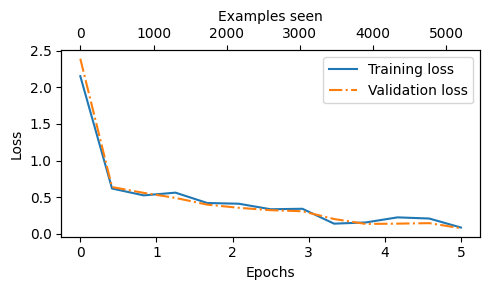

In [6]:
# -----------------------------------------------------------------------------
# 3. 메인 실행 블록
# -----------------------------------------------------------------------------

test_mode = False
########################################
# 1단계: 데이터셋 다운로드 및 준비
########################################

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "datas/sms_spam_collection.zip"
extracted_path = "datas/sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

try:
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)
except (requests.exceptions.RequestException, TimeoutError) as e:
    print(f"Primary URL failed: {e}. Trying backup URL...")
    url = "https://f001.backblazeb2.com/file/LLMs-from-scratch/sms%2Bspam%2Bcollection.zip"
    download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

# 데이터 로드 및 전처리
df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
balanced_df = create_balanced_dataset(df) # 50:50 균형 데이터셋 생성
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1}) # 라벨 인코딩

# Train/Val/Test 분할 및 CSV 저장
train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
train_df.to_csv("datas/train.csv", index=None)
validation_df.to_csv("datas/validation.csv", index=None)
test_df.to_csv("datas/test.csv", index=None)

########################################
# 2단계: 데이터 로더 생성
########################################
tokenizer = tiktoken.get_encoding("gpt2")

# 학습 데이터셋 생성
train_dataset = SpamDataset(
    csv_file="datas/train.csv",
    max_length=None, # 가장 긴 문장에 맞춰 자동 설정
    tokenizer=tokenizer
)

# 검증/테스트 데이터셋은 학습 데이터셋의 max_length를 따름 (일관성 유지)
val_dataset = SpamDataset(
    csv_file="datas/validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

test_dataset = SpamDataset(
    csv_file="datas/test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

num_workers = 0
batch_size = 8
torch.manual_seed(123)

# DataLoader 생성
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True, # 학습 데이터는 섞음
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

########################################
# 3단계: 사전 학습된 모델 로드 (Pre-trained Model Loading)
########################################

if test_mode:
    # 테스트 모드일 때는 아주 작은 더미 모델 생성
    BASE_CONFIG = {
        "vocab_size": 50257,
        "context_length": 120,
        "drop_rate": 0.0,
        "qkv_bias": False,
        "emb_dim": 12,
        "n_layers": 1,
        "n_heads": 2
    }
    model = GPTModel(BASE_CONFIG)
    model.eval()
    device = "cpu"

else:
    # 실제 GPT-2 Small (124M 파라미터) 모델 설정 및 가중치 로드
    CHOOSE_MODEL = "gpt2-small (124M)"
    
    BASE_CONFIG = {
        "vocab_size": 50257,     
        "context_length": 1024,  
        "drop_rate": 0.0,        
        "qkv_bias": True         
    }

    model_configs = {
        "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
        # 다른 모델 사이즈 설정들...
        "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
        "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
        "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
    }

    BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

    # 데이터셋의 길이가 모델의 컨텍스트 길이를 초과하는지 확인
    assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
        f"Dataset length {train_dataset.max_length} exceeds model's context "
        f"length {BASE_CONFIG['context_length']}. Reinitialize data sets with "
        f"`max_length={BASE_CONFIG['context_length']}`"
    )

    model_name = "gpt2-small-124M.pth"
    model = load_gpt2_model(model_name, BASE_CONFIG)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

########################################
# 4단계: 모델 수정 및 미세 조정 설정 (Fine-tuning Setup)
########################################

# 1. 모든 파라미터를 고정(Freeze)하여 학습되지 않게 설정
for param in model.parameters():
    param.requires_grad = False

torch.manual_seed(123)

# 2. 출력층(Head) 교체: 기존 50257개 단어 예측 -> 2개 클래스(스팸/햄) 예측
# 이 새로운 층은 기본적으로 requires_grad=True 상태임
num_classes = 2
# region [출력층(Head) 교체]
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)
# endregion

model.to(device)

# 3. 추가적으로 마지막 트랜스포머 블록과 정규화 층을 학습 가능하도록 잠금 해제 (Unfreeze)
# -> 이렇게 하면 출력층과 모델의 마지막 부분만 데이터에 맞게 조정됨 (효율적 학습)
# region [마지막 트랜스포머 블록과 정규화 층 잠금 해제]
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True
# endregion

########################################
# 5단계: 모델 미세 조정 (Fine-tuning) 실행
########################################

start_time = time.time()
torch.manual_seed(123)

# 옵티마이저 설정 (학습 가능한 파라미터만 전달됨)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
# 학습 함수 호출
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

########################################
# 6단계: 결과 시각화
########################################

# Loss 그래프 그리기
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))
plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

# Accuracy 그래프 그리기
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))
plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")